In [52]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from neo4j import GraphDatabase
import warnings   
  
# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

import sys

sys.path.insert(1, 'C:/Users/tom/projects/skill-skeleton/')
sys.path.insert(2, 'C:/Users/tom/projects/skill-skeleton/utils/')
sys.path.insert(3, 'C:/Users/tom/projects/skill-skeleton/utils/neo4j/')
import graph


def add_skills(rows, batch_size=10000):
    # Adds skill nodes to the Neo4j graph as a batch job.

    query = '''UNWIND $rows AS row
    MERGE (s:Skill {name: row.skill, category: row.tag})
    RETURN count(*) as total
    '''
    return insert_data(query, rows, batch_size)


def add_profiles(rows, batch_size=10000):
    # Adds profile nodes to the Neo4j graph as a batch job.

    query = '''UNWIND $rows AS row
     CREATE (p:Profile {name:row.profile})
    RETURN count(*) as total
    '''
    return insert_data(query, rows, batch_size)


def add_links(rows, batch_size=5000):
    # Adds profile nodes and (:Profile)--(:Skill)
    # relationships to the Neo4j graph as a batch job.  (Note the smaller batch
    # size due to the fact that this function is adding much more data than the
    # add_skills() function.)

    query = '''
    UNWIND $rows as row   
    WITH row
    MATCH (p:Profile {name: row.profile})   
    MATCH (s:Skill {name: row.skill})
    MERGE (p)-[:HAS {score: row.score, version: row.version}]->(s)
    RETURN count(distinct p) as total
    '''

    return insert_data(query, rows, batch_size)


def insert_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.

    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        total += res[0]['total']
        batch += 1
        result = {"total":total, "batches":batch, "time":time.time()-start}
        print(result)

    return result

def get_skills(df):
        return df[['skill', 'tag']].drop_duplicates()
        
        
def get_profiles(df):
    return df[['profile']].drop_duplicates()


def populate_db(df):
    skills = get_skills(df)
    profiles = get_profiles(df)        
    
    add_skills(skills)
    add_profiles(profiles)
    add_links(df)


def configure_db():
    conn.query('CREATE CONSTRAINT profiles IF NOT EXISTS FOR (p:Profile) REQUIRE p.name IS UNIQUE')
    conn.query('CREATE CONSTRAINT skills IF NOT EXISTS FOR (s:Skill) REQUIRE s.name IS UNIQUE')


def setup_db(file):
    df = pd.read_csv(file)
    configure_db()
    populate_db(df)


def get_total_skill_count_by_profile(profile_name):
    parameters = {'profile_name': profile_name}

    query_string = '''
    MATCH (p:Profile {name: $profile_name})-[r:HAS]->(s:Skill)    
    RETURN count(*) as total
    '''
    return conn.query(query_string,parameters=parameters)[0]['total']


def get_skills_by_profile_and_category(profile_name, category_name, min_score=5):
    parameters = {'profile_name': profile_name,
                  'category_name': category_name,
                  'min_score': min_score
                  }

    query_string = '''
    MATCH (p:Profile {name: $profile_name})-[r:HAS]->(s:Skill) 
    WHERE r.score > $min_score AND s.category = $category_name
    RETURN p.name as profile, s.name as skill, r.score as score
    ORDER BY score DESC
    '''
    return pd.DataFrame([dict(_) for _ in conn.query(query_string,parameters=parameters)])


def get_score_by_skills(skills, min_score=5):
    parameters = {'skills': skills,
                  'min_score': min_score
                  }

    query_string = '''
    MATCH (p:Profile)-[r:HAS]->(s:Skill) 
    WHERE r.score > $min_score AND s.name in $skills
    RETURN p.name as profile, s.name as skill, r.score as score
    ORDER BY score DESC
    '''
    return pd.DataFrame([dict(_) for _ in conn.query(query_string,parameters=parameters)])


def get_remaining_skills_by_profile(profile_name, skills, min_score=5, limit=10):
    parameters = {'profile_name': profile_name,
                  'skills': skills,
                  'min_score': min_score,
                  'limit': limit
                  }

    query_string = '''
    MATCH (p:Profile {name: $profile_name})-[r:HAS]->(s:Skill) 
    WHERE r.score > $min_score AND not s.name in $skills
    RETURN s.name as skill, r.score as score
    ORDER BY score DESC LIMIT $limit
    '''
    return pd.DataFrame([dict(_) for _ in conn.query(query_string,parameters=parameters)])





class Neo4jConnection:
        
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))                  
            
        except Exception as e:
            print("Failed to create the driver:", e)
        
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
        
    def query(self, query, parameters=None, db="profile-kb", response_type="list"):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
                    
                    
            if response_type == "graph":              
                #response = self.__driver.execute_query(query, result_transformer_=neo4j.Result.graph)
                response = session.run(query, parameters).graph()
            else:
                response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response
    
   
conn = Neo4jConnection(uri="bolt://localhost:7687", 
                       user="neo4j",              
                       pwd="neo4jneo4j")

In [ ]:
input_file = "profile-kb.csv"
#setup_db(input_file)

In [76]:
skills = get_skills_by_profile_and_category('Data Engineer', 'Tools', 5)
skills.head(20)

,profile,skill,score
0,Data Engineer,Tableau,12.0
1,Data Engineer,Power BI,9.6
2,Data Engineer,SSIS,5.5


In [77]:
print(skills['score'].sum())

27.1


In [31]:
my_skills = ['SQL','PyTorch','Pandas','R']
skill_count = len(my_skills)
profile_score = get_score_by_skills(my_skills, 5)
print(profile_score)

match_profile_count = profile_score.groupby(['profile'])['profile'].value_counts()
df = pd.DataFrame({'profile':match_profile_count.index, 'count':match_profile_count.values})

match_profile_total_score = profile_score.groupby(['profile'])['score'].sum()
df2 = pd.DataFrame({'profile':match_profile_total_score.index, 'total_score':match_profile_total_score.values})

df['max'] = df['profile'].apply(get_total_skill_count_by_profile)
df['coverage'] = (df['count'] / df['max'])*100

merged_df = df.merge(df2, on="profile")

merged_df.sort_values(by=['coverage', 'total_score'], ascending=[False,False], inplace=True)
print(merged_df)

print(get_total_skill_count_by_profile('Data Engineer'))

          profile    skill  score
0   Data Engineer      SQL   64.8
1  Data Scientist      SQL   48.0
2    Data Analyst      SQL   47.3
3  Data Scientist        R   37.9
4    Data Analyst        R   16.5
5  Data Scientist  PyTorch    9.4
6  Data Scientist   Pandas    9.3
7   Data Engineer        R    8.0
          profile  count  max  coverage  total_score
2  Data Scientist      4  125  3.200000        104.6
0    Data Analyst      2  105  1.904762         63.8
1   Data Engineer      2  123  1.626016         72.8
123


Data Scientist
        skill  score
0      Python   68.9
1     Tableau   20.2
2         AWS   16.3
3       Spark   15.4
4       Azure   13.1
5  TensorFlow   12.2
6        Java   10.4
7       Excel   10.1
8    Power BI    9.6
9      Hadoop    9.4


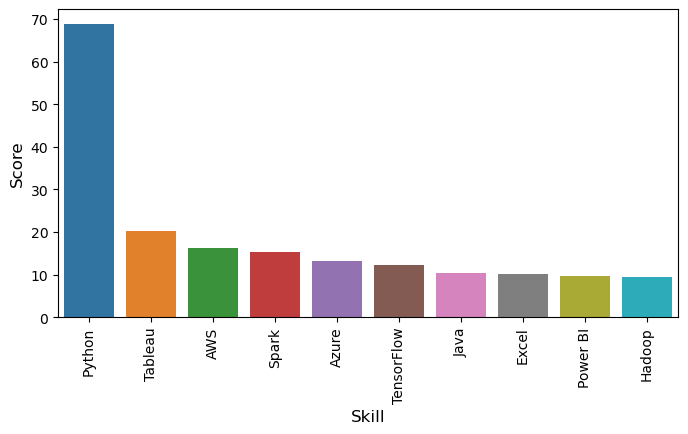

In [33]:
chosen_profile = merged_df.iloc[0]['profile']
print(chosen_profile)

to_learn = get_remaining_skills_by_profile(chosen_profile, my_skills)
print(to_learn)
graph.show_skill_score_graph(to_learn)

<Axes: >

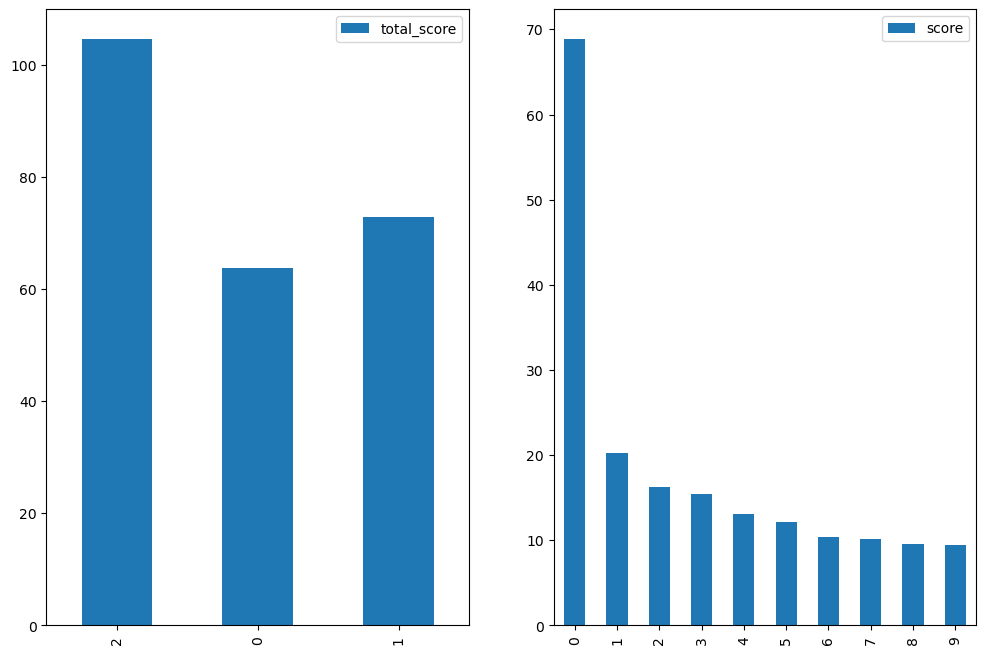

In [36]:
fig, axes = plt.subplots(figsize=(12,8),nrows=1, ncols=2)

merged_df[["profile","total_score"]].plot(ax=axes[0], kind='bar')
to_learn[["skill","score"]].plot(ax=axes[1], kind='bar')